In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import os
import warnings
import unicodedata
warnings.filterwarnings('ignore')

In [75]:
def clean_text(text):
    """
    Limpia y normaliza el texto manteniendo caracteres especiales importantes
    """
    if not isinstance(text, str):
        text = str(text)
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Reemplazar múltiples espacios con uno solo
    text = re.sub(r'\s+', ' ', text)
    
    # Eliminar espacios al inicio y final
    text = text.strip()
    
    return text

def process_training_data(filename='TRAINING_DATA.txt'):
    """
    Procesa el archivo de entrenamiento
    """
    sentences = []
    labels = []
    
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                label, text = line.strip().split('\t')
                sentences.append(clean_text(text))
                labels.append(int(label))
    
    return pd.DataFrame({
        'text': sentences,
        'label': labels
    })

def process_test_data(filename='REAL_DATA.txt'):
    """
    Procesa el archivo de prueba, eliminando el "2\t" inicial
    """
    sentences = []
    
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                # Separar por tab y tomar solo el texto
                _, text = line.strip().split('\t')
                cleaned_text = clean_text(text)
                sentences.append(cleaned_text)
    
    return pd.DataFrame({
        'text': sentences
    })

In [76]:
def preprocess_text(text):
    """
    Realiza el preprocesamiento básico del texto
    """
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar caracteres especiales y números
    text = re.sub(r'[^a-záéíóúñü\s]', '', text)
    
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Descargar recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/victorg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victorg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [77]:
def create_features(train_df, test_df):
    """
    Crea características usando TF-IDF
    """
    # Inicializar TF-IDF Vectorizer
    tfidf = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        preprocessor=preprocess_text
    )
    
    # Fit y transform en datos de entrenamiento
    X_train = tfidf.fit_transform(train_df['sentence'])
    
    # Transform en datos de prueba
    X_test = tfidf.transform(test_df['sentence'])
    
    return X_train, X_test, tfidf

In [78]:
def train_evaluate_models(X_train, y_train):
    """
    Entrena y evalúa múltiples modelos
    """
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Naive Bayes': MultinomialNB(),
        'Linear SVM': LinearSVC(max_iter=2000)
    }
    
    trained_models = {}
    
    # Dividir datos de entrenamiento en train y validación
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    for name, model in models.items():
        print(f"\nEntrenando {name}...")
        model.fit(X_train_split, y_train_split)
        
        # Evaluar en conjunto de validación
        val_pred = model.predict(X_val)
        print(f"\nResultados de validación para {name}:")
        print(classification_report(y_val, val_pred))
        
        # Guardar modelo entrenado
        trained_models[name] = model
        
        # Visualizar matriz de confusión
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_val, val_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusión - {name}')
        plt.ylabel('Valor Real')
        plt.xlabel('Predicción')
        plt.show()
    
    return trained_models


In [79]:
def analyze_features(model, tfidf, n_features=20):
    """
    Analiza las características más importantes para la clasificación
    """
    if isinstance(model, LogisticRegression):
        coef = model.coef_[0]
    elif isinstance(model, LinearSVC):
        coef = model.coef_[0]
    else:
        return
    
    feature_names = tfidf.get_feature_names_out()
    
    # Características más importantes para cada clase
    top_positive = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coef
    }).nlargest(n_features, 'coefficient')
    
    top_negative = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coef
    }).nsmallest(n_features, 'coefficient')
    
    # Visualización
    plt.figure(figsize=(12, 8))
    
    plt.subplot(1, 2, 1)
    sns.barplot(data=top_positive, x='coefficient', y='feature')
    plt.title('Características más importantes\npara traducción humana')
    
    plt.subplot(1, 2, 2)
    sns.barplot(data=top_negative, x='coefficient', y='feature')
    plt.title('Características más importantes\npara traducción automática')
    
    plt.tight_layout()
    plt.show()

In [80]:
def make_predictions(model, X_test):
    """
    Realiza predicciones en el conjunto de prueba
    """
    predictions = model.predict(X_test)
    return predictions

In [74]:
def main():
    try:
        # Procesar datos de entrenamiento
        print("Procesando datos de entrenamiento...")
        train_df = process_training_data()
        print(f"Datos de entrenamiento cargados: {len(train_df)} filas")
        print("\nPrimeras 3 filas de datos de entrenamiento:")
        print(train_df.head(3))
        
        # Procesar datos de prueba
        print("\nProcesando datos de prueba...")
        test_df = process_test_data()
        print(f"Datos de prueba cargados: {len(test_df)} filas")
        print("\nPrimeras 3 filas de datos de prueba:")
        print(test_df.head(3))
        
        # Guardar datos procesados
        train_df.to_csv('clean_training_data.csv', index=False)
        test_df.to_csv('clean_test_data.csv', index=False)
        
        print("\nDatos guardados en:")
        print("- clean_training_data.csv")
        print("- clean_test_data.csv")
        
        # Mostrar distribución de etiquetas en datos de entrenamiento
        print("\nDistribución de etiquetas en datos de entrenamiento:")
        print(train_df['label'].value_counts())
        
    except Exception as e:
        print(f"Error en la ejecución: {str(e)}")
        raise

if __name__ == "__main__":
    main()

Procesando datos de entrenamiento...
Datos de entrenamiento cargados: 17877 filas

Primeras 3 filas de datos de entrenamiento:
                                                text  label
0  cuando conocí a janice en 2013 , una familia n...      1
1  hwang habló en sur de este año por southwest m...      0
2  usted podría pensar katy perry y robert pattin...      1

Procesando datos de prueba...
Datos de prueba cargados: 2201 filas

Primeras 3 filas de datos de prueba:
                                                text
0  yo no creo que a nadie le haya encantado un pe...
1  no va a resolver sus problemas de crédito o me...
2                                te encantará este !

Datos guardados en:
- clean_training_data.csv
- clean_test_data.csv

Distribución de etiquetas en datos de entrenamiento:
label
0    8939
1    8938
Name: count, dtype: int64


In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_data():
    """
    Carga los datos procesados
    """
    train_df = pd.read_csv('clean_training_data.csv')
    test_df = pd.read_csv('clean_test_data.csv')
    return train_df, test_df

def create_features(train_df, test_df, max_features=5000):
    """
    Crea características usando TF-IDF
    """
    print("Creando características con TF-IDF...")
    
    # Inicializar TF-IDF
    tfidf = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),  # Unigramas y bigramas
        min_df=2,  # Ignorar términos que aparecen en menos de 2 documentos
        max_df=0.95  # Ignorar términos que aparecen en más del 95% de los documentos
    )
    
    # Transformar datos
    X_train = tfidf.fit_transform(train_df['text'])
    X_test = tfidf.transform(test_df['text'])
    
    print(f"Dimensiones de los datos transformados:")
    print(f"Training: {X_train.shape}")
    print(f"Test: {X_test.shape}")
    
    return X_train, X_test, tfidf

In [82]:
def train_evaluate_models(X_train, y_train):
    """
    Entrena y evalúa múltiples modelos
    """
    # Dividir datos de entrenamiento en train y validación
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Naive Bayes': MultinomialNB(),
        'Linear SVM': LinearSVC(max_iter=2000)
    }
    
    best_score = 0
    best_model = None
    
    for name, model in models.items():
        print(f"\nEntrenando {name}...")
        model.fit(X_train_split, y_train_split)
        
        # Evaluar en conjunto de validación
        score = model.score(X_val, y_val)
        print(f"Puntuación de validación: {score:.4f}")
        
        # Predicciones detalladas
        y_pred = model.predict(X_val)
        print("\nReporte de clasificación:")
        print(classification_report(y_val, y_pred))
        
        # Matriz de confusión
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confusión - {name}')
        plt.ylabel('Real')
        plt.xlabel('Predicción')
        plt.show()
        
        # Guardar el mejor modelo
        if score > best_score:
            best_score = score
            best_model = model
    
    return best_model

In [83]:
def get_feature_importance(model, tfidf, n_top=20):
    """
    Obtiene las características más importantes del modelo
    """
    if isinstance(model, (LogisticRegression, LinearSVC)):
        coefficients = model.coef_[0]
        feature_names = tfidf.get_feature_names_out()
        
        # Características más importantes para cada clase
        top_positive = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients
        }).nlargest(n_top, 'coefficient')
        
        top_negative = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients
        }).nsmallest(n_top, 'coefficient')
        
        # Visualización
        plt.figure(figsize=(15, 10))
        
        plt.subplot(1, 2, 1)
        sns.barplot(data=top_positive, x='coefficient', y='feature')
        plt.title('Características más importantes\npara traducción humana')
        
        plt.subplot(1, 2, 2)
        sns.barplot(data=top_negative, x='coefficient', y='feature')
        plt.title('Características más importantes\npara traducción automática')
        
        plt.tight_layout()
        plt.show()


Cargando datos...
Creando características con TF-IDF...
Dimensiones de los datos transformados:
Training: (17877, 5000)
Test: (2201, 5000)

Entrenando modelos...

Entrenando Logistic Regression...
Puntuación de validación: 0.4620

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.45      0.46      0.46      1751
           1       0.47      0.46      0.47      1825

    accuracy                           0.46      3576
   macro avg       0.46      0.46      0.46      3576
weighted avg       0.46      0.46      0.46      3576



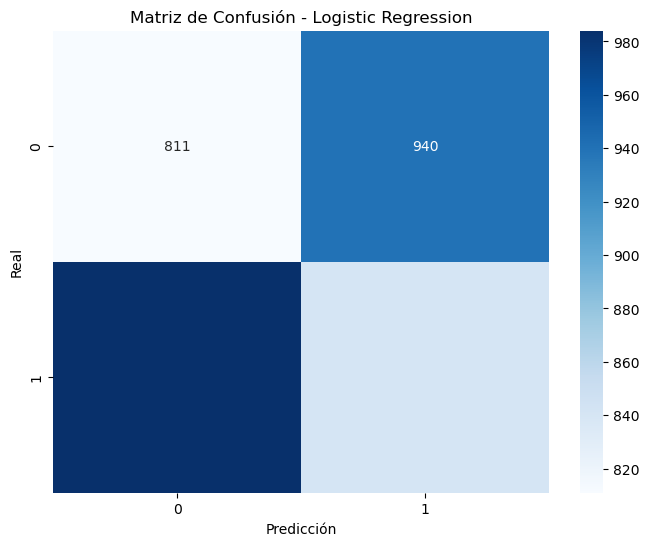


Entrenando Naive Bayes...
Puntuación de validación: 0.4329

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.42      0.45      0.44      1751
           1       0.44      0.42      0.43      1825

    accuracy                           0.43      3576
   macro avg       0.43      0.43      0.43      3576
weighted avg       0.43      0.43      0.43      3576



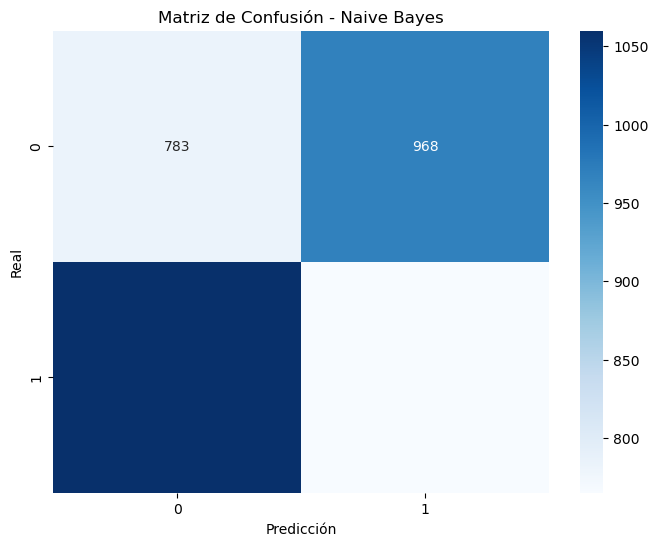


Entrenando Linear SVM...
Puntuación de validación: 0.4385

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43      1751
           1       0.45      0.44      0.45      1825

    accuracy                           0.44      3576
   macro avg       0.44      0.44      0.44      3576
weighted avg       0.44      0.44      0.44      3576



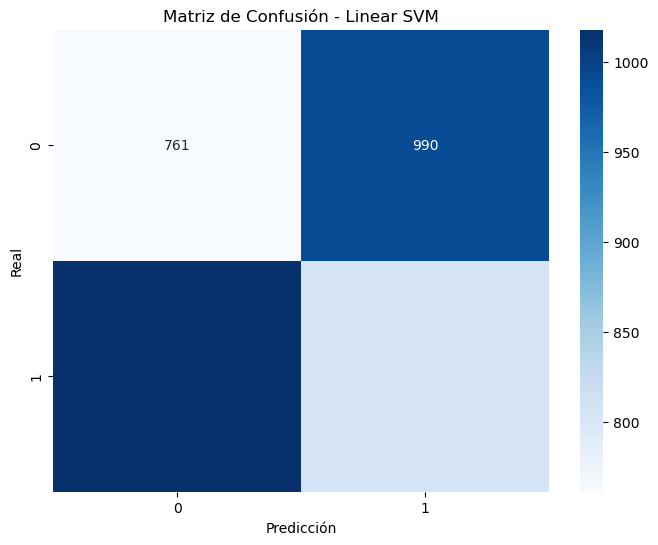


Analizando características importantes...


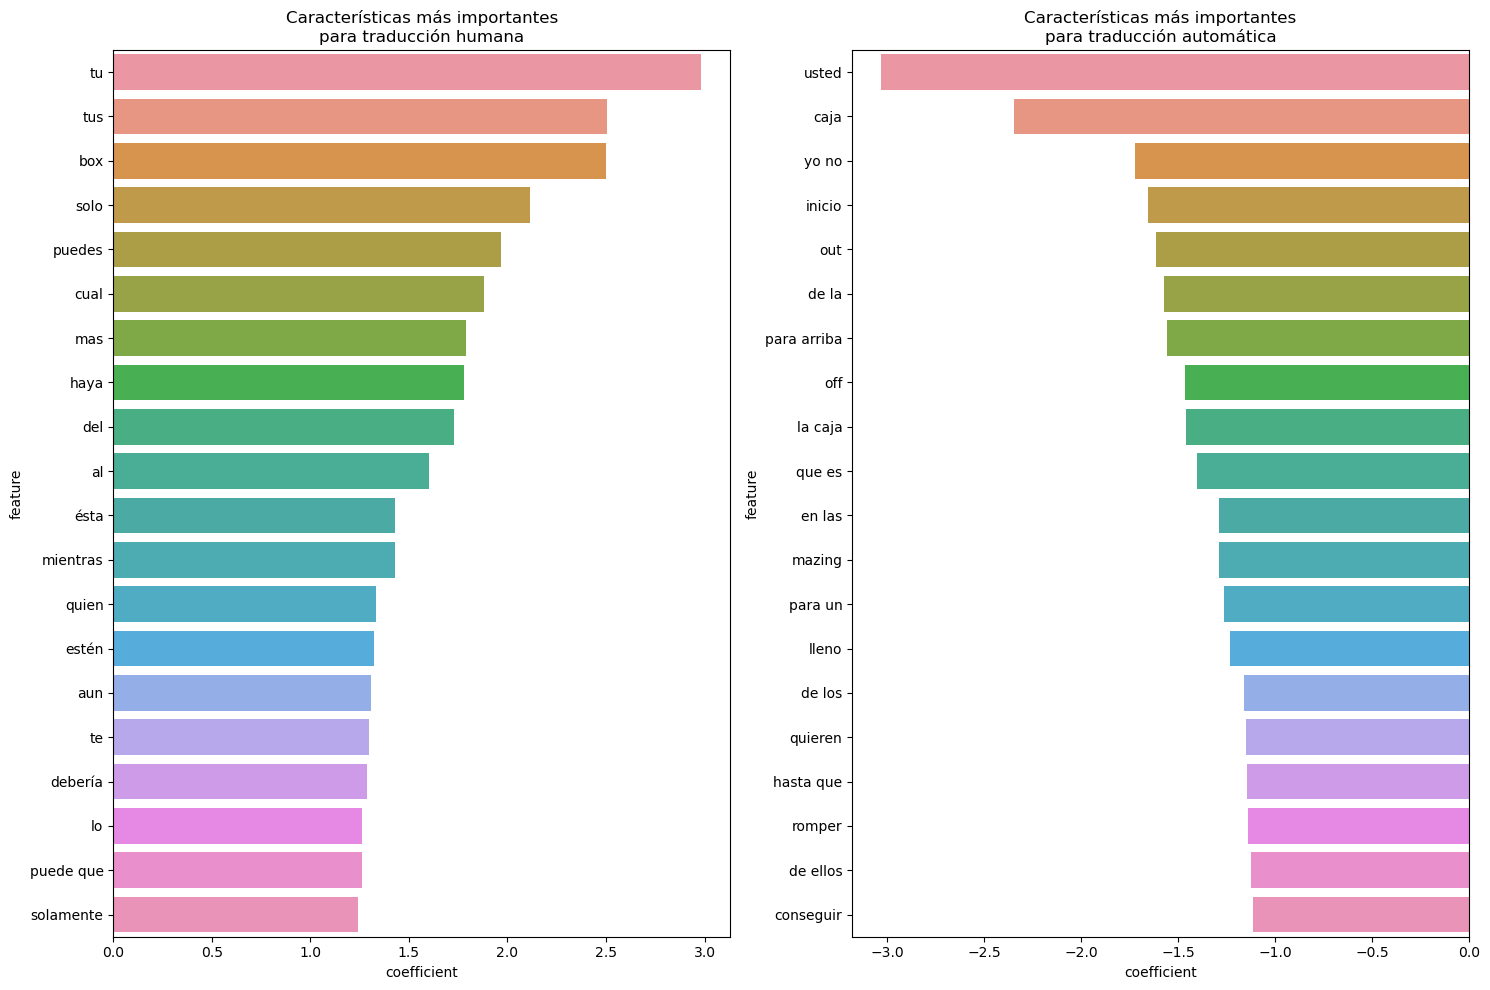


Generando predicciones finales...

Distribución de predicciones en datos de prueba:
0    1167
1    1034
Name: count, dtype: int64


In [84]:
def main():
    # Cargar datos
    print("Cargando datos...")
    train_df, test_df = load_data()
    
    # Crear características
    X_train, X_test, tfidf = create_features(train_df, test_df)
    
    # Entrenar y evaluar modelos
    print("\nEntrenando modelos...")
    best_model = train_evaluate_models(X_train, train_df['label'])
    
    # Analizar características importantes
    print("\nAnalizando características importantes...")
    get_feature_importance(best_model, tfidf)
    
    # Realizar predicciones finales
    print("\nGenerando predicciones finales...")
    final_predictions = best_model.predict(X_test)
    
    # Guardar predicciones
    predictions_df = pd.DataFrame({
        'text': test_df['text'],
        'predicted_label': final_predictions
    })
    predictions_df.to_csv('predictions.csv', index=False)
    
    # Mostrar distribución de predicciones
    print("\nDistribución de predicciones en datos de prueba:")
    print(pd.Series(final_predictions).value_counts())

if __name__ == "__main__":
    main()

In [85]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
print("Cargando datos...")
train_df = pd.read_csv('clean_training_data.csv')
test_df = pd.read_csv('clean_test_data.csv')

print(f"Datos cargados:")
print(f"Training: {train_df.shape}")
print(f"Test: {test_df.shape}")

# Crear TF-IDF
print("\nCreando vectorización TF-IDF...")
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Transformar datos
X_train = tfidf.fit_transform(train_df['text'])
X_test = tfidf.transform(test_df['text'])

# Entrenar modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(max_iter=2000)
}

best_score = 0
best_model = None

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train, train_df['label'])
    score = model.score(X_train, train_df['label'])
    print(f"Score de entrenamiento: {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_model = model

# Generar predicciones
print("\nGenerando predicciones finales...")
predictions = best_model.predict(X_test)

# Guardar resultados
predictions_df = pd.DataFrame({
    'text': test_df['text'],
    'predicted_label': predictions
})
predictions_df.to_csv('predictions.csv', index=False)

print("\nDistribución de predicciones:")
print(pd.Series(predictions).value_counts())
print("\nPredicciones guardadas en 'predictions.csv'")

Cargando datos...
Datos cargados:
Training: (17877, 2)
Test: (2201, 1)

Creando vectorización TF-IDF...

Entrenando Logistic Regression...
Score de entrenamiento: 0.6563

Entrenando Naive Bayes...
Score de entrenamiento: 0.6442

Entrenando Linear SVM...
Score de entrenamiento: 0.6883

Generando predicciones finales...

Distribución de predicciones:
1    1106
0    1095
Name: count, dtype: int64

Predicciones guardadas en 'predictions.csv'
